# Assignment-1 COMP-5630 Jacob Murrah

## README
This notebook performs linear regression modeling on an unlabeled dataset and a housing dataset. It includes data loading and model training using the normal equation, evaluation using MSE, and visualization of the results.

## Dependencies
- **Python 3.x**
- **pandas**
- **numpy**
- **matplotlib**

*Note: If you are running this notebook in Google Colab, all the required packages are pre-installed.*

## Instructions
1. **Run All Cells:**  
   Please click on "Runtime" > "Run all" to execute the entire notebook sequentially.
2. **Review the Outputs:**  
   The notebook is organized into several sections. Ensure that all cells run without errors.

In [516]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Question #1 Intro
Suppose that you are conducting a scientific experiment where you are observing the effects of one variable (x_train.npy and x_test.npy) on the output (y_train.npy and y_test.npy). Your goal is to come up with a linear regression model that can take the training data (x_train.npy and y_train.npy) and model the relationship between the variables x and y. You should implement your own version of linear regression either using gradient descent or normal equations.

### Question #1-1) Plotting Training Data
###### Try to plot this relationship on your own using matplotlib. You can also visualize the test data to see if it gives you any clues about the underlying relationship between the variables.


In [517]:
x_train, x_test = np.load('x_train.npy').reshape(-1, 1), np.load('x_test.npy').reshape(-1, 1)
y_train, y_test = np.load('y_train.npy').reshape(-1, 1), np.load('y_test.npy').reshape(-1, 1)

###### First I want to view our raw data.

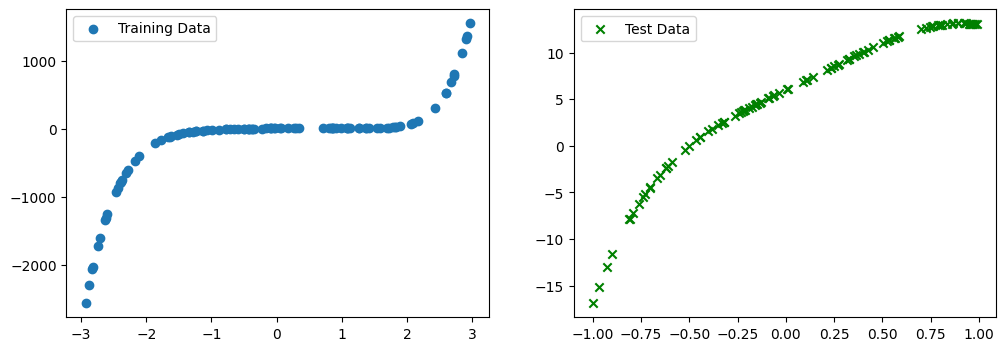

In [518]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.scatter(x_train, y_train, label="Training Data")
ax1.legend()

ax2.scatter(x_test, y_test, color='green', marker='x', label="Test Data")
ax2.legend()

plt.show()

###### Initially the training data and test data appear to take on a different relationship. The training data appears to model a cubic relationship or an even higher degree odd power and the x data points fall between -3 and 3. The test data appears to follow a linear or logarithmic relationship but the x data points start at -1 and end at 1.

###### After scaling both datasets I notice that the testing data x axis values fall between -0.5 and 0.7 and only falls between 0.18 and 0.24 on the y axis which is a very small range. The training data between from x equals -0.5 to 0.7 has y axis values that fall right above 0 but due to the scale it is hard to interpret anything from the training data. <br><br> I am going to plot the datapoints from the training data that only fall between -0.5 and 0.7 on the x axis and 0.18 and 0.24 on the y axis and see how that compares to the testing data.

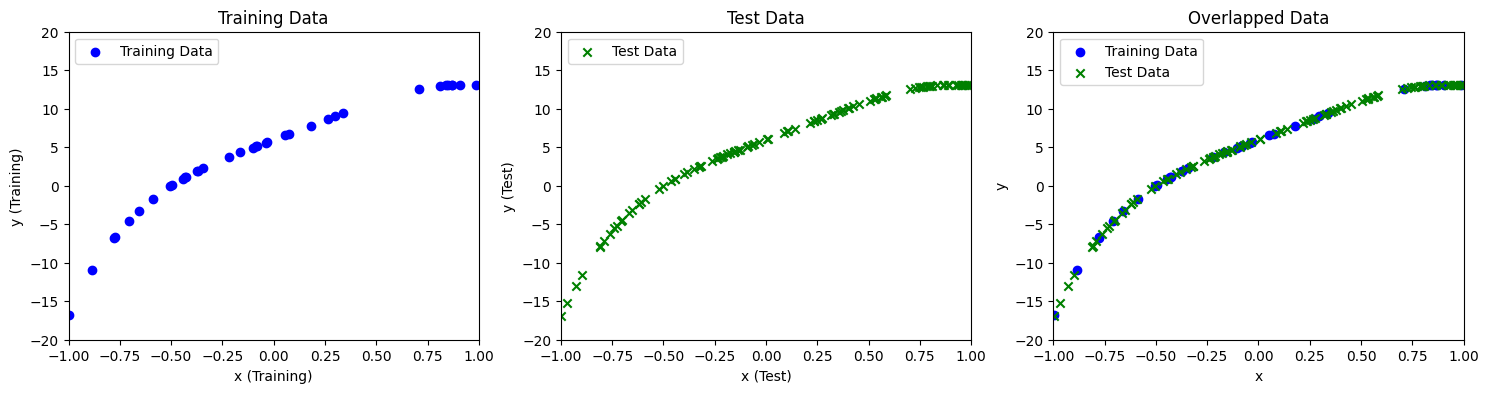

In [519]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

ax1.scatter(x_train, y_train, color='blue', label="Training Data")
ax1.set_xlabel("x (Training)")
ax1.set_ylabel("y (Training)")
ax1.set_xlim(-1, 1)
ax1.set_ylim(-20, 20)
ax1.legend(loc="upper left")
ax1.set_title("Training Data")

ax2.scatter(x_test, y_test, color='green', marker='x', label="Test Data")
ax2.set_xlabel("x (Test)")
ax2.set_ylabel("y (Test)")
ax2.set_xlim(-1, 1)
ax2.set_ylim(-20, 20)
ax2.legend(loc="upper left")
ax2.set_title("Test Data")

ax3.scatter(x_train, y_train, color='blue', label="Training Data")
ax3.scatter(x_test, y_test, color='green', marker='x', label="Test Data")
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_xlim(-1, 1)
ax3.set_ylim(-20, 20)
ax3.legend(loc="upper left")
ax3.set_title("Overlapped Data")

plt.show()

###### When displaying the training data at the same scale and range as the test data we can see a very clear relationship! This is exciting and now we can start thinking about how to model this relationship. <br><br> My initial thought is that we need to model the entire relationship of the training data in order to accurately predict new values that fall outside the range of our testing data. I will create a design matrix to model the very clearly non-linear relationship.

### Question #1-2) Answering Questions Related to Data
###### Use your knowledge gleaned from the previous step to answer the following questions:
<ol type="a">
  <li>Is the relationship linear?</li>
  <p><b>Answer:</b> No! The training data is flat from -2 and 2 and approaches -&infin; and +&infin; as x reaches -3 and 3 respectively.</p>
  <li>Do you need feature engineering to add any non-linearity?</li>
  <p><b>Answer:</b> Yes, we can use feature engineering to add non-linearity.</p>
  <ol type="i">
    <li>If so, how can you engineer these features?</li>
    <p><b>Answer:</b> First we need to keep in mind that we have a feature vector and a weight vector. We can add features and weights based on the shape of our graphed data and test them out! Specifically adding features with higher degrees like x<sup>3</sup> or other math functions like log(x) can be useful.</p>
    <li>What are some functions that you can try?</li>
    <p><b>Answer:</b> My initial intuition is that the relationship is similar to x<sup>3</sup> due to the exponentional nature of the graph. Since we need to maintain negative values we can exclude even powers like x<sup>2</sup> and we've already ruled out linear relationships like 7x + 2.</p>
    <p>I assume the relationship will not exactly match any specific polynomial so I will create a design matrix to create multiple features where each feature has a polynomial basis function.
    I plan on using 5-fold cross validation to find the best value. Since we only have one feature x<sub>1</sub> I will test basis functions for x<sup>1</sup> to x<sup>9</sup> in order to see which models the data the best.</p>
  </ol>
</ol>

### Question #1) Report and Implementation

###### I will use normal equations to solve for two linear regression models to demonstrate the varying degrees of complexity that can be modeled using linear regression. <br>
1. Model 1 will be complex and utilize polynomial basis functions to model the training data and predict the testing data as accurately as possible.
2. Model 2 will be simple and only have a single feature in order to be utilized in the second question. This model will not be as accurate due to the simplicity of the model.



In [520]:
def solve_normal_equation(x, y):
    xTx_inv = np.linalg.inv(np.matmul(x.T, x))
    xTy = np.matmul(x.T, y)
    return np.matmul(xTx_inv, xTy)

def mse(actual, predicted):
  return np.mean((actual - predicted) ** 2)

In [521]:
# Polynomial (Complex) Linear Regression Model
powers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

X_train_poly = np.hstack([np.ones((x_train.shape[0], 1))] + [x_train**p for p in powers])
X_test_poly = np.hstack([np.ones((x_test.shape[0], 1))] + [x_test**p for p in powers])

theta_poly = solve_normal_equation(X_train_poly, y_train).flatten()
y_pred_poly = np.matmul(X_test_poly, theta_poly)

formula_poly = f"y = {theta_poly[0]:.3f}" + "".join(
    f" {'+' if c >= 0 else '-'} {abs(c):.3f}x^{p}"
    for p, c in zip(powers, theta_poly[1:])
    if abs(c) > 0.00001
)

print("Complex Model Formula:", formula_poly)
print(f"Test MSE for the Complex Model: {mse(y_test, y_pred_poly):.3f}")

Complex Model Formula: y = 6.000 + 10.000x^1 + 4.000x^3 - 8.000x^4 + 1.000x^7
Test MSE for the Complex Model: 101.984


In [522]:
# Simple Linear Regression Model
X_train_lin = np.hstack([np.ones((x_train.shape[0], 1)), x_train])
X_test_lin  = np.hstack([np.ones((x_test.shape[0], 1)), x_test])

theta_lin = solve_normal_equation(X_train_lin, y_train).flatten()
y_pred_lin = np.matmul(X_test_lin, theta_lin)

formula_lin = f"y = {theta_lin[0]:.3f} + {theta_lin[1]:.3f}x"

print("Simple Linear Regression Formula:", formula_lin)
print(f"Test MSE for the Simple Model: {mse(y_test, y_pred_lin):.3f}")

Simple Linear Regression Formula: y = -106.174 + 300.620x
Test MSE for the Simple Model: 37658.119


###### After building our models let's plot the models with our actual data to visualize how each fits the training and test data.

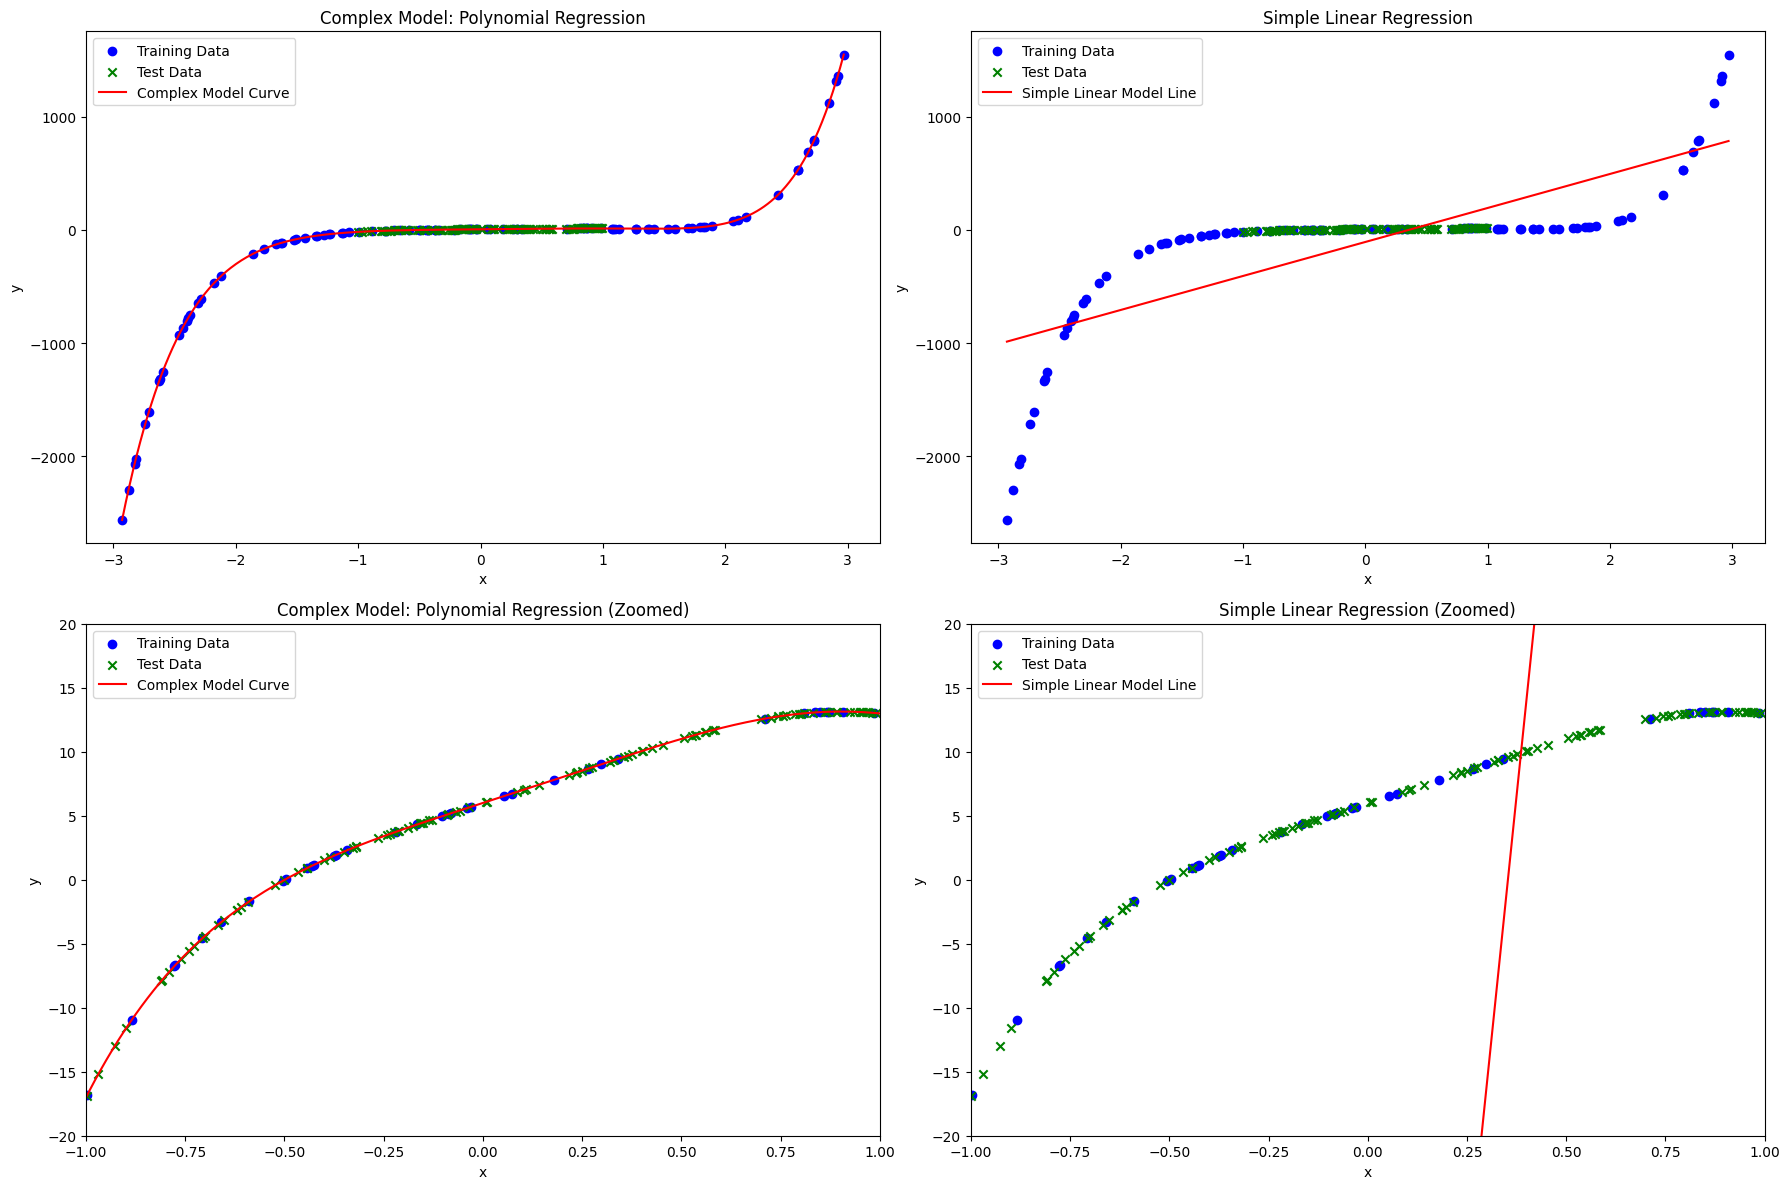

In [523]:
x_dense = np.linspace(np.min(x_train), np.max(x_train), 400).reshape(-1, 1)

X_dense_poly = np.hstack([np.ones((x_dense.shape[0], 1))] + [x_dense**p for p in powers])
y_dense_poly = np.matmul(X_dense_poly, theta_poly)

X_dense_lin = np.hstack([np.ones((x_dense.shape[0], 1)), x_dense])
y_dense_lin = np.matmul(X_dense_lin, theta_lin)


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# Complex Model Plot (Row 1, Column 1)
ax1.scatter(x_train, y_train, color='blue', label="Training Data")
ax1.scatter(x_test, y_test, color='green', marker='x', label="Test Data")
ax1.plot(x_dense, y_dense_poly, color='red', label="Complex Model Curve")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Complex Model: Polynomial Regression")
ax1.legend(loc="upper left")

# Simple Linear Regression Plot (Row 1, Column 2)
ax2.scatter(x_train, y_train, color='blue', label="Training Data")
ax2.scatter(x_test, y_test, color='green', marker='x', label="Test Data")
ax2.plot(x_dense, y_dense_lin, color='red', label="Simple Linear Model Line")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("Simple Linear Regression")
ax2.legend(loc="upper left")

# Complex Model Zoomed Plot (Row 2, Column 1)
ax3.scatter(x_train, y_train, color='blue', label="Training Data")
ax3.scatter(x_test, y_test, color='green', marker='x', label="Test Data")
ax3.plot(x_dense, y_dense_poly, color='red', label="Complex Model Curve")
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_title("Complex Model: Polynomial Regression (Zoomed)")
ax3.legend(loc="upper left")
ax3.set_xlim(-1, 1)
ax3.set_ylim(-20, 20)

# Simple Linear Regression Zoomed Plot (Row 2, Column 2)
ax4.scatter(x_train, y_train, color='blue', label="Training Data")
ax4.scatter(x_test, y_test, color='green', marker='x', label="Test Data")
ax4.plot(x_dense, y_dense_lin, color='red', label="Simple Linear Model Line")
ax4.set_xlabel("x")
ax4.set_ylabel("y")
ax4.set_title("Simple Linear Regression (Zoomed)")
ax4.legend(loc="upper left")
ax4.set_xlim(-1, 1)
ax4.set_ylim(-20, 20)

plt.tight_layout()
plt.show()

###### Question #1 Conclusion)

Complex Model:
The polynomial model, which incorporates higher-order terms, was able to capture the non-linear trends in the training data. The computed equation is:
<p>y = 6.000 + 10.000*x^1 + 4.000*x^3 - 8.000*x^4 + 1.000*x^7</p>

This complex model achieved a test MSE of 101.984, indicating that it captures the underlying non-linear trends very well.
<br><br>
Simple Model:
The simple linear regression model was significantly less complex, producing an equation of:
<p>y = -106.174 + 300.620*x</p>

With a higher test MSE of 37658.119, it is clear that a linear model does not capture the non-linear relationship as effectively.
<br><br>
Based on the analysis, the relationship between x and y is non-linear. The complex polynomial linear regression model provided a superior fit. The simple linear model, while easier to interpret, did not capture the full complexity of the relationship.

Feature engineering and basis functions can be essential in modeling non-linear relationships, especially when the raw data exhibits clear non-linearity.


### Question #2 Intro

###### Imagine that you are a realtor in Auburn. You have data points (See excel file. Last column is the target variable.) that correspond to the recent sales of different houses in and around Auburn. Your goal is to help estimate the prices of houses that one can use to sell or buy listings. Can you use your knowledge of linear regression to find the best regression model? Use your implementation from Question 1 (without any basis functions) to answer the following questions.

In [524]:
train_data = pd.read_excel('Housing_data_regression.xlsx', sheet_name='Train')
test_data = pd.read_excel('Housing_data_regression.xlsx', sheet_name='Test')

x_train = train_data.iloc[:, 1:-1].to_numpy()
y_train = train_data.iloc[:, -1].to_numpy()
x_test = test_data.iloc[:, 1:-1].to_numpy()
y_test = test_data.iloc[:, -1].to_numpy()

###### Creating a simple linear regression model to model each feature in the housing data

In [525]:
# Simple Linear Regression Model
X_train = np.hstack([np.ones((x_train.shape[0], 1)), x_train])
X_test = np.hstack([np.ones((x_test.shape[0], 1)), x_test])

theta = solve_normal_equation(X_train, y_train).flatten()
y_train_pred = np.matmul(X_train, theta)
y_test_pred  = np.matmul(X_test, theta)

train_mse = mse(y_train, y_train_pred)
test_mse = mse(y_test, y_test_pred)

feature_names = train_data.columns[1:-1]
coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': np.round(theta[1:], 3)
})
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)

print(coefficients.to_string())
print(f"\nTraining MSE: {train_mse:.3f}")
print(f"Testing MSE: {test_mse:.3f}")

       Feature  Coefficient
2  Living area   228669.130
0    Bathrooms   209185.845
4      # Rooms   113529.579
3    # Garages    47994.960
1    Land Area    10192.815
6  Age of home    -2133.474
5   # Bedrooms  -151116.118

Training MSE: 5006561505.204
Testing MSE: 56870641738.099


### Question #2) Questions




###### 1) What is the average least squares error for the given data using your simple linear regression model?
Answer: <br>
The MSE values for the training and testing data are as follows: <br>TRAINING MSE = 5006561505.204
<br>TESTING MSE = 56870641738.099
<br>These values are both shown in the output above when using the simple linear regression model.
<br>

###### 2) Which factor has the most effect on the final value? How do you know this? Can you use only this feature to predict the price?
Answer: <br>
Living Area has the most effect! Because we’re using a simple linear regression model, the predictor with the largest coefficient magnitude will have the greatest impact on the final predicted value. In our model, Living Area stands out due to it having the coefficient with the greatest magnitude, meaning that changes in Living Area drives the largest changes in the estimated housing price (remember, our model is of the form y = mx + b, where m is the coefficient). Although you could use only Living Area to predict the price, including all the features generally leads to a more accurate and robust prediction.
<br>
###### 3) Which factor has the least effect on the final value? How do you know this? What effect does removing this feature have on the performance?
Answer: <br>
Age of home has the least effect! Because we’re using a simple linear regression model, the factor with the smallest magnitude for the coefficient will have the least influence on the final predicted value. In our model, Age of home has a coefficient that is much smaller than the coefficients for the other features. Removing Age of home from the model would likely have only a minimal effect on overall performance since its contribution to the predicted price is very low. While it might simplify the model slightly, the best overall prediction accuracy is generally achieved when all relevant features are included.